# TREC

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim.downloader

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df_train=pd.read_csv("/Users/zhanglikang/Desktop/SC4002_G06/datasets/TREC/train.csv")
df_train["text"] = df_train["text"].str.lower()
print(len(df_train))
print(df_train.shape)
df_train.head()

df_test=pd.read_csv("/Users/zhanglikang/Desktop/SC4002_G06/datasets/TREC/test.csv")
df_test["text"] = df_test["text"].str.lower()

5452
(5452, 3)


In [3]:
# Split the data to create a development set of 500 examples
train_data, dev_data = train_test_split(df_train, test_size=500, random_state=42)
test_data = df_test

# Display the size of the training and development sets
len(train_data), len(dev_data)

(4952, 500)

## Update Word2Vec

In [4]:
print(list(gensim.downloader.info()['models'].keys()))

# Download the "glove-twitter-25" embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

# retrieve the vector for 'computer'
# glove_vectors['computer'] 

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
# Out-of-vocabulary (OOV) words
# 1. can be replaced with a special token, such as "<OOV>" or "<UNK>".
# 2. can be ignored.

word2idx = w2v.key_to_index
print(f"whether <UNK> in w2v: {'<UNK>' in word2idx}") # False
print(f"whether <PAD> in w2v: {'<PAD>' in word2idx}") # False

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

whether <UNK> in w2v: False
whether <PAD> in w2v: False
word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001


In [6]:
print(w2v.vectors.shape)
w2v['computer'].shape

(3000000, 300)


(300,)

In [7]:
# add the '<UNK>' word to the vocabulary of the Word2Vec model 
# initialize it with the average of all word vectors int he pretrained embeddings.
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])
print("after insert UNK: ", w2v.vectors.shape)

# add the '<PAD>' word to the vocabulary of the Word2Vec model 
# initialize it with a row of zeros in the vectors matrix.
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])
print("after insert UNK: ", w2v.vectors.shape)

after insert UNK:  (3000001, 300)
after insert UNK:  (3000002, 300)


## Modify Class Labels

In [8]:
# Get unique coarse labels
unique_labels = train_data['label-coarse'].unique()

# Randomly select 4 classes
np.random.seed(19260817)
selected_labels = np.random.choice(unique_labels, size=4, replace=False)

# ****** 6 == OTHERS !!!!!! IMPORTANT 
# update: 6 will cause error, change back to OTHERS then transform later

train_data['new_label'] = train_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
dev_data['new_label'] = dev_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
test_data['new_label'] = test_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")

# Display the unique labels in the updated training set
train_data['new_label'].unique()

array([2, 0, 'OTHERS', 4, 3], dtype=object)

In [12]:
label_encoder = LabelEncoder()


test_data['new_label'] = test_data['new_label'].astype(str)
test_data["label_transformed"] = label_encoder.fit_transform(test_data['new_label'])

train_data['new_label'] = train_data['new_label'].astype(str)
train_data["label_transformed"] = label_encoder.fit_transform(train_data['new_label'])

dev_data['new_label'] = dev_data['new_label'].astype(str)
dev_data["label_transformed"] = label_encoder.fit_transform(dev_data['new_label'])

In [13]:
train_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
4943,2,34,what is mikhail gorbachev 's middle initial ?,2,1
2346,0,0,how does the tail affect the flight of a kite ?,0,0
1835,5,21,what were the first three cities to have a pop...,OTHERS,4
4047,1,1,what is the movie jonathan livingstone seagull ?,OTHERS,4
5097,1,23,what is a fear of home surroundings ?,OTHERS,4


In [14]:
dev_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
3408,5,21,what city is served by tempelhol airport ?,OTHERS,4
371,1,2,what is dudley do-right 's horse 's name ?,OTHERS,4
453,0,9,what 's nature 's purpose for tornadoes ?,0,0
290,0,12,what is the history of valentine 's day cards ?,0,0
4457,3,4,what president became chief justice after his ...,3,2


In [15]:
test_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
0,4,40,how far is it from denver to aspen ?,4,3
1,5,21,"what county is modesto , california in ?",OTHERS,4
2,3,12,who was galileo ?,3,2
3,0,7,what is an atom ?,0,0
4,4,8,when did hawaii become a state ?,4,3


## Add \<UNK> && \<PAD>

In [16]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]


class TRECDataset(Dataset):
    def __init__(self, sentences, tags, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.tags = [torch.tensor(tag) for tag in tags]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

def collate_fn(batch):
    sentences, tags = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    return sentences_padded, tags

# Create PyTorch datasets and data loaders
train_dataset = TRECDataset(train_data['text'], train_data['label_transformed'], word2idx)
dev_dataset = TRECDataset(dev_data['text'], dev_data['label_transformed'], word2idx)
test_dataset = TRECDataset(test_data['text'], test_data['label_transformed'], word2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


## Training, Evaluation and Visualization function

**Since Dataloader is fixed, try to use below functions for easy-training-implementation**

In [18]:


def train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer):
    train_losses = []
    dev_losses = []
    train_accuracies = []
    dev_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for sentences, tag_tuple in train_loader:
            model.zero_grad()
            tags = torch.stack(tag_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, tags)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += tags.size(0)
            correct += (predicted == tags).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(total_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        dev_loss = 0
        correct_dev = 0
        total_dev = 0
        with torch.no_grad():
            for sentences, tag_tuple in dev_loader:
                tags = torch.stack(tag_tuple)
                predictions = model(sentences)
                
                loss = loss_function(predictions, tags)
                dev_loss += loss.item()
                
                _, predicted = torch.max(predictions, 1)
                total_dev += tags.size(0)
                correct_dev += (predicted == tags).sum().item()
                
        dev_accuracies.append(100 * correct_dev / total_dev)
        dev_losses.append(dev_loss/len(dev_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Dev Accuracy: {dev_accuracies[-1]:.2f}%")

    return train_losses, dev_losses, train_accuracies, dev_accuracies

In [19]:
def evaluate_model(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for sentences, tag_tuple in test_loader:
            tags = torch.stack(tag_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, tags)
            test_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total_test += tags.size(0)
            correct_test += (predicted == tags).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_loss, test_accuracy

In [20]:
def visualize(train_losses, dev_losses, train_accuracies, dev_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, dev_losses, 'r*-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, dev_accuracies, 'r*-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Model 1

In [21]:
weights = torch.FloatTensor(w2v.vectors)

# Build nn.Embedding() layer
embedding = nn.Embedding.from_pretrained(weights)
# embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=vocab.get('<PAD>', None), freeze=True)
embedding.requires_grad = False

embedding_matrix = torch.FloatTensor(w2v.vectors)


# Define the model architecture
class QuestionClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)

        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim

        return x

In [24]:
# Hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique tags/labels
VOCAB_SIZE = len(word2idx)
TAGSET_SIZE = 5

model = QuestionClassifier(EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

In [25]:
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

Epoch 1/100, Train Loss: 1.4114, Dev Loss: 1.3809, Train Accuracy: 38.15%, Dev Accuracy: 39.00%
Epoch 2/100, Train Loss: 1.3608, Dev Loss: 1.3693, Train Accuracy: 38.99%, Dev Accuracy: 39.40%
Epoch 3/100, Train Loss: 1.3489, Dev Loss: 1.3647, Train Accuracy: 39.74%, Dev Accuracy: 42.60%
Epoch 4/100, Train Loss: 1.3411, Dev Loss: 1.3639, Train Accuracy: 40.79%, Dev Accuracy: 43.00%
Epoch 5/100, Train Loss: 1.3286, Dev Loss: 1.3525, Train Accuracy: 41.62%, Dev Accuracy: 42.40%
Epoch 6/100, Train Loss: 1.3260, Dev Loss: 1.3477, Train Accuracy: 42.04%, Dev Accuracy: 43.00%
Epoch 7/100, Train Loss: 1.3200, Dev Loss: 1.3402, Train Accuracy: 42.39%, Dev Accuracy: 43.60%
Epoch 8/100, Train Loss: 1.3123, Dev Loss: 1.3369, Train Accuracy: 43.07%, Dev Accuracy: 43.00%
Epoch 9/100, Train Loss: 1.3097, Dev Loss: 1.3337, Train Accuracy: 43.54%, Dev Accuracy: 43.40%
Epoch 10/100, Train Loss: 1.3092, Dev Loss: 1.3306, Train Accuracy: 44.35%, Dev Accuracy: 44.60%
Epoch 11/100, Train Loss: 1.3047, Dev L

Epoch 86/100, Train Loss: 1.2493, Dev Loss: 1.2829, Train Accuracy: 46.63%, Dev Accuracy: 45.40%
Epoch 87/100, Train Loss: 1.2515, Dev Loss: 1.2812, Train Accuracy: 47.07%, Dev Accuracy: 46.00%
Epoch 88/100, Train Loss: 1.2554, Dev Loss: 1.2956, Train Accuracy: 47.21%, Dev Accuracy: 45.20%
Epoch 89/100, Train Loss: 1.2541, Dev Loss: 1.2808, Train Accuracy: 46.81%, Dev Accuracy: 43.80%
Epoch 90/100, Train Loss: 1.2460, Dev Loss: 1.2909, Train Accuracy: 47.39%, Dev Accuracy: 43.80%
Epoch 91/100, Train Loss: 1.2476, Dev Loss: 1.2810, Train Accuracy: 46.69%, Dev Accuracy: 44.00%
Epoch 92/100, Train Loss: 1.2495, Dev Loss: 1.2838, Train Accuracy: 47.48%, Dev Accuracy: 46.20%
Epoch 93/100, Train Loss: 1.2555, Dev Loss: 1.2812, Train Accuracy: 46.65%, Dev Accuracy: 44.40%
Epoch 94/100, Train Loss: 1.2500, Dev Loss: 1.2852, Train Accuracy: 47.37%, Dev Accuracy: 45.20%
Epoch 95/100, Train Loss: 1.2561, Dev Loss: 1.2808, Train Accuracy: 46.95%, Dev Accuracy: 46.60%
Epoch 96/100, Train Loss: 1.25

In [26]:
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.2501, Test Accuracy: 43.40%


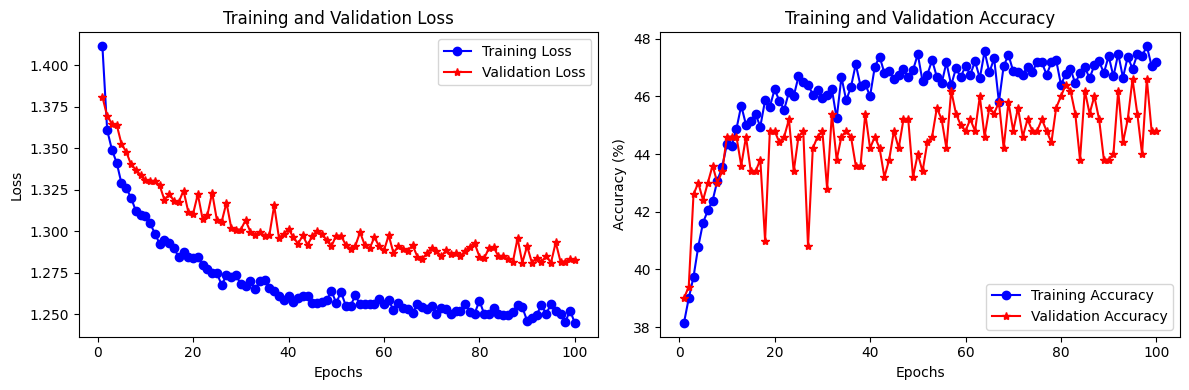

In [27]:
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

# **Below Code is still Bullshit       :-(**

In [18]:
def get_sentence_embeddings(sentence, model):
    embeddings = []
    for word in sentence.split():
        if word in model:
            embeddings.append(model[word])
        else:
            embeddings.append(np.zeros(300))
    return embeddings

# def embedding(df, model):
#     embeddings_list = []
#     new_labels_list = []
    
#     for index, row in df.iterrows():
#         sentence = row['text']
#         embeddings = get_sentence_embeddings(sentence, model)
        
#         # Appending the embeddings and the corresponding new_label to the lists
#         embeddings_list.append(embeddings)
#         new_labels_list.append(row['new_label'])
    
#     # Creating the new dataframes
#     X_train = pd.DataFrame({'embeddings': embeddings_list})
#     Y_train = pd.DataFrame({'new_label': new_labels_list})
    
#     return X_train, Y_train

def embedding(df, model):
    embeddings_list = []
    new_labels_list = []
    
    for index, row in df.iterrows():
        sentence = row['text']
        embeddings = get_sentence_embeddings(sentence, model)
        
        # Appending the embeddings and the corresponding new_label to the lists
        embeddings_list.append(embeddings)
        new_labels_list.append(row['new_label'])
    
    return embeddings_list, new_labels_list

In [19]:
X_train, Y_train = embedding(train_data, word2idx)
X_dev, Y_dev = embedding(dev_data, word2idx)


## Use a simple linear layer + Averaging all word vectors


In [20]:
import numpy as np

# # Convert object-type DataFrame to list of arrays
# X_train_arrays = list(X_train.apply(lambda x: np.array(x)))

# Stack arrays
X_train_stacked = np.vstack(X_train)

# Convert to PyTorch tensor
X_train_tensor = torch.tensor(X_train_stacked, dtype=torch.float32)


# # Convert object-type DataFrame to list of arrays
# X_test_arrays = list(X_test.apply(lambda x: np.array(x)))

# Stack arrays
X_dev_stacked = np.vstack(X_dev)

# Convert to PyTorch tensor
X_dev_tensor = torch.tensor(X_dev_stacked, dtype=torch.float32)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['new_label'])
y_dev = label_encoder.transform(dev_data['new_label'])

y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.int64)

In [ ]:
X_train_tensor.shape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model architecture
class QuestionClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)
        
        # Output Layer
        x = self.output(x)
        return x

# Define Hyperparameters
EMBEDDING_DIM = 300  # As each word vector is of shape (300,)
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 4 integer classes + 1 "OTHERS"
EPOCHS = 100
LR = 0.001

# # Convert dataframes to tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Instantiate the model
model = QuestionClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    
    optimizer.zero_grad()
    
    predictions = model(X_train_tensor)
    loss = criterion(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch: {epoch}/{EPOCHS}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    _, predicted = test_predictions.max(1)
    accuracy = (predicted == Y_test_tensor).float().mean()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
class QuestionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.hidden(x)
        x = torch.mean(x, dim=1)  # Aggregation Layer
        x = self.output(x)
        return nn.functional.softmax(x, dim=1)

In [ ]:
# Hyperparameters
input_dim = 300  # word2vec dimensions
hidden_dim = 128
output_dim = 5  # 5 classes
lr = 0.01

# Model, Loss, Optimizer
model = QuestionClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
epochs = 1000

train_data = pd.DataFrame()  # Assuming train_data is already loaded as mentioned
dev_data = pd.DataFrame()    # Assuming dev_data is also loaded



In [ ]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for index, row in train_data.iterrows():
        optimizer.zero_grad()
        sentence = row['text']
        label = row['new_label']

        sentence_embeddings = torch.tensor(get_sentence_embeddings(sentence, glove_vectors)).float().unsqueeze(0)
        
        outputs = model(sentence_embeddings)
        loss = criterion(outputs, torch.tensor([label]).long())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    model.eval()
    predictions = []
    true_labels = []
    for index, row in dev_data.iterrows():
        sentence = row['text']
        label = row['new_label']
        true_labels.append(label)
        
        with torch.no_grad():
            sentence_embedding = torch.tensor(get_sentence_embedding(sentence, glove_vectors)).float().unsqueeze(0)
            outputs = model(sentence_embedding)
            predicted_class = torch.argmax(outputs).item()
            predictions.append(predicted_class)
            
    dev_accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {np.mean(train_losses)}, Dev Accuracy: {dev_accuracy:.2f}")

print("Training complete.")

In [ ]:
# Function to get the average word vector for a sentence
def sentence_vector(sentence):
    words = sentence.split()
    # Split the sentence into words.

    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    # Get the word vector for each word in the sentence if it exists in glove_vectors.


    if len(vectors) == 0: # to avoid empty lists
        return np.zeros(300)
    # If no words from the sentence are in the word vectors, return a vector of zeros.

    return np.mean(vectors, axis=0)
# Return the average word vector for the sentence.

train_data['avg_vector'] = train_data['text'].apply(sentence_vector)
# Compute the average word vector for each sentence in the training data.

X_train = np.vstack(train_data['avg_vector'].values)
# Stack the average vectors to form the training data.

y_train = pd.get_dummies(train_data['new_label']).values
# Convert the new labels to one-hot encoded vectors.

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Convert the training data to a PyTorch tensor.

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)
# Convert the one-hot encoded labels to their corresponding class indices.


In [ ]:
# Neural Network Model with a simple linear layer
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        # Initialize the parent class.
        
        self.fc = nn.Linear(input_dim, output_dim)
        # Define a fully connected layer.

    def forward(self, x):
        return self.fc(x)
    # Define the forward pass to return the output of the linear layer.

input_dim = 300  # as we're using word2vec-google-news-300
# Define the input dimension based on the word vector size.

output_dim = 5  # for our 5 new classes
# Define the output dimension based on the number of new classes.

model = SimpleClassifier(input_dim, output_dim)
# Initialize the model.

criterion = nn.CrossEntropyLoss()
# Define the loss function (cross entropy).

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the optimizer (Adam) with a learning rate.

# Training
epochs = 5000
# Set the number of epochs.

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()
  


    # Store metrics for visualization
    all_metrics['A']['epochs'].append(epoch)
    all_metrics['A']['accuracy'].append(accuracy)
    all_metrics['A']['loss'].append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")
    # Print the loss and accuracy for each epoch.


In [ ]:
visualize_metrics(all_metrics['A'])

## Use a feedforward network which is a combination of a linear transformation and a nonlinear activation function

## Max pooling over the word vectors

In [ ]:
def sentence_vector(sentence):
    words = sentence.split()
    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    if len(vectors) == 0: # if no words in the sentence have embeddings
        return np.zeros(300)
    return np.max(vectors, axis=0) # max pooling across the words

train_data['maxpooled_vector'] = train_data['text'].apply(sentence_vector)

X_train = np.vstack(train_data['maxpooled_vector'].values)
y_train = pd.get_dummies(train_data['new_label']).values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)

In [ ]:
train_data.head()

In [ ]:
# Define the neural network model with feedforward layers
class FeedForwardClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardClassifier, self).__init__()
        
        # First linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Second linear layer that outputs class probabilities
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Apply first linear transformation
        x = self.fc1(x)
        
        # Apply ReLU activation function
        x = nn.ReLU()(x)
        
        # Apply second linear transformation
        return self.fc2(x)

input_dim = 300  # as we're using word2vec-google-news-300
hidden_dim = 1000  # can be adjusted based on performance
output_dim = 5   # for our 5 new classes

model = FeedForwardClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()

    # Store metrics for visualization
    all_metrics['B']['epochs'].append(epoch)
    all_metrics['B']['accuracy'].append(accuracy)
    all_metrics['B']['loss'].append(loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")


In [ ]:
visualize_metrics(all_metrics['B'])

##  Recurrent neural network
##  Aggregation Layer: Taking the representation of the last word (useful if using RNNs)

In [ ]:
def sentence_matrix(sentence, max_len=30):
    words = sentence.split()[:max_len]  # truncate if necessary
    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    while len(vectors) < max_len:  # pad if necessary
        vectors.append(np.zeros(300))
    return np.array(vectors)

train_data['vector_matrix'] = train_data['text'].apply(sentence_matrix)

X_train = np.stack(train_data['vector_matrix'].values)
y_train = pd.get_dummies(train_data['new_label']).values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)

In [ ]:
train_data.head()

In [ ]:
# Define the neural network model with an RNN layer
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        
        # Linear layer that outputs class probabilities
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Pass the input through the RNN layer
        out, _ = self.rnn(x)
        
        # Only take the output from the final timestep
        out = out[:, -1, :]
        
        # Pass the final output through the linear layer
        return self.fc(out)

input_dim = 300  # as we're using word2vec-google-news-300
hidden_dim = 100  # can be adjusted based on performance
output_dim = 5   # for our 5 new classes

model = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()

    # Store metrics for visualization
    all_metrics['C']['epochs'].append(epoch)
    all_metrics['C']['accuracy'].append(accuracy)
    all_metrics['C']['loss'].append(loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")


In [ ]:
visualize_metrics(all_metrics['C'])